We should implement and back-test trading algorithms using historical market data.

The project is divided into three main strategies:

1. Moving Average and Momentum Strategies,
2. Value-Based Strategies, and
3. Sentiment-Based Strategies.

Write our own Back Testing Code

▪ Back Testing simulates how a trading strategy would have performed in the past using historical data.
▪ The purpose is to evaluate the strategy's effectiveness, identify potential issues, and refine it before deploying it in live trading.
▪ Here are key components a back-testing code needs to handle:
    1. Load up and process price and other data
    2. Clean and prepare data
    3. Implement logic to buy and sell based on signals
    4. Define trades and measure their performance over time
    5. Incorporate realistic transaction costs
    6. Calculate metrics – return, drawdown, Sharpe ratio etc.…
    7. Visualise results

Validation and Sanity Checks

▪ Out-of-Sample Testing:
    ▪ After optimizing the strategy on historical data, test it on a separate dataset (out-of-sample data) to verify its robustness.
▪ Sanity Checks:
    ▪ Ensure the backtest is realistic (e.g., no future data leakage, no unrealistic execution assumptions) to prevent overestimating the strategy’s performance.

In [ ]:
import pandas as pd

# Load the stock data
file_path = "/mnt/data/stock_data.csv"
df = pd.read_csv(file_path)

# Display basic information and the first few rows
df.info(), df.head()

# Convert Date column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Sort data by Date
df = df.sort_values("Date").reset_index(drop=True)

# Forward-fill missing values to maintain continuity
df.fillna(method="ffill", inplace=True)

# Drop columns where more than 50% of data is missing
threshold = len(df) * 0.5
df = df.dropna(axis=1, thresh=threshold)

# Remove any duplicate rows if present
df = df.drop_duplicates()

# Display cleaned dataset info
df.info(), df.head()

# Define the new file path
cleaned_file_path = "/mnt/data/cleaned_stock_data.csv"

# Save the cleaned dataset to CSV
df.to_csv(cleaned_file_path, index=False)

# Return the file path for download
cleaned_file_path

# Drop rows where any column has missing values to keep only complete data
df_complete = df.dropna()

# Save the fully cleaned dataset
complete_file_path = "/mnt/data/fully_cleaned_stock_data.csv"
df_complete.to_csv(complete_file_path, index=False)

# Return the file path for download
complete_file_path


Strategy 1: Moving Average and Momentum Strategies

Rules based Moving average startegy

Understand & implement moving average strategies
    ▪ Simple Moving Average (SMA)
    ▪ Write code that calculates this to different periods

Tasks:
    1. Implement a strategy where a short-term moving average (e.g., S-day SMA) crosses above or below a long-term moving average (e.g., L-day SMA).
    2. Write code to execute buy orders when the short-term average crosses above the long-term average and sell orders when the opposite occurs.
    3. Test the algorithm on a broad range of stocks (at least 100) from the S&P index for a range of values of S and L
    4. You should report average P&L and variance of P&L for each combination of moving average periods

In [1]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

# -------------------------------
# Helper Functions to Compute Indicators
# -------------------------------

def compute_indicators_for_stock(df, ma_periods, rsi_period=14):
    """
    Given a DataFrame with columns 'Date' and 'Price', compute moving averages for each period in ma_periods
    and compute the RSI using the specified rsi_period.
    """
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Compute moving averages
    for period in ma_periods:
        df[f"MA {period}"] = df['Price'].rolling(window=period).mean()
    
    # Compute RSI (using the standard 14-day period by default)
    delta = df['Price'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=rsi_period).mean()
    avg_loss = loss.rolling(window=rsi_period).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    return df

# -------------------------------
# Simulation Functions for Strategies
# -------------------------------

def simulate_ma_strategy(df, short_window, long_window):
    """
    Simulate a moving average crossover strategy:
      - Buy when the short MA crosses above the long MA.
      - Sell when the short MA crosses below the long MA.
    """
    trades = []
    in_position = False
    entry_price = 0.0

    ma_short = df[f"MA {short_window}"]
    ma_long  = df[f"MA {long_window}"]
    price    = df['Price']

    for i in range(1, len(df)):
        # Buy signal: short MA crosses above long MA
        if not in_position and (ma_short.iloc[i] > ma_long.iloc[i]) and (ma_short.iloc[i-1] <= ma_long.iloc[i-1]):
            in_position = True
            entry_price = price.iloc[i]
        # Sell signal: short MA crosses below long MA
        elif in_position and (ma_short.iloc[i] < ma_long.iloc[i]) and (ma_short.iloc[i-1] >= ma_long.iloc[i-1]):
            exit_price = price.iloc[i]
            trades.append(exit_price - entry_price)
            in_position = False

    # Close any open position at the end of the series
    if in_position:
        trades.append(price.iloc[-1] - entry_price)
        
    return trades

def simulate_rsi_strategy(df, rsi_buy_threshold, rsi_sell_threshold):
    """
    Simulate an RSI-based strategy:
      - Buy when RSI exceeds the buy threshold.
      - Sell when RSI falls below the sell threshold.
    """
    trades = []
    in_position = False
    entry_price = 0.0
    price = df['Price']
    rsi   = df['RSI']

    for i in range(len(df)):
        if not in_position and (rsi.iloc[i] > rsi_buy_threshold):
            in_position = True
            entry_price = price.iloc[i]
        elif in_position and (rsi.iloc[i] < rsi_sell_threshold):
            exit_price = price.iloc[i]
            trades.append(exit_price - entry_price)
            in_position = False

    if in_position:
        trades.append(price.iloc[-1] - entry_price)
    return trades

def simulate_combined_strategy(df, short_window, long_window, rsi_buy_threshold, rsi_sell_threshold):
    """
    Simulate a combined strategy:
      - Buy when a short MA crosses above a long MA and RSI exceeds the buy threshold.
      - Sell when a short MA crosses below a long MA and RSI falls below the sell threshold.
    """
    trades = []
    in_position = False
    entry_price = 0.0
    price = df['Price']
    ma_short = df[f"MA {short_window}"]
    ma_long  = df[f"MA {long_window}"]
    rsi      = df['RSI']

    for i in range(1, len(df)):
        if not in_position and (ma_short.iloc[i] > ma_long.iloc[i]) and (ma_short.iloc[i-1] <= ma_long.iloc[i-1]) and (rsi.iloc[i] > rsi_buy_threshold):
            in_position = True
            entry_price = price.iloc[i]
        elif in_position and (ma_short.iloc[i] < ma_long.iloc[i]) and (ma_short.iloc[i-1] >= ma_long.iloc[i-1]) and (rsi.iloc[i] < rsi_sell_threshold):
            exit_price = price.iloc[i]
            trades.append(exit_price - entry_price)
            in_position = False

    if in_position:
        trades.append(price.iloc[-1] - entry_price)
    return trades

# -------------------------------
# Wrapper Functions for Parallel Processing
# -------------------------------

def get_trades_for_ticker_ma(df, s, l):
    if f"MA {s}" in df.columns and f"MA {l}" in df.columns:
        return simulate_ma_strategy(df, s, l)
    return []

def get_trades_for_ticker_rsi(df, rsi_buy, rsi_sell):
    if 'RSI' in df.columns:
        return simulate_rsi_strategy(df, rsi_buy, rsi_sell)
    return []

def get_trades_for_ticker_combined(df, s, l, rsi_buy, rsi_sell):
    if (f"MA {s}" in df.columns) and (f"MA {l}" in df.columns) and ('RSI' in df.columns):
        return simulate_combined_strategy(df, s, l, rsi_buy, rsi_sell)
    return []

# -------------------------------
# Main Backtesting Process
# -------------------------------

# Load the CSV file.
# The CSV is assumed to have the first column as "Date" and all subsequent columns are adjusted close prices for S&P 500 stocks.
data = pd.read_csv('DF_fully_cleaned_stock_data.csv', parse_dates=['Date'])
data.sort_values('Date', inplace=True)

# All columns except 'Date' represent different stocks.
tickers = data.columns[1:]

# Define the moving average periods of interest.
short_windows = [5, 7, 10, 15, 20]
long_windows  = [50, 70, 100, 150, 200]
ma_periods = sorted(list(set(short_windows + long_windows)))

# Build a dictionary with processed DataFrames for each ticker.
stock_dfs = {}
for ticker in tickers:
    df_stock = data[['Date', ticker]].rename(columns={ticker: 'Price'})
    df_stock = compute_indicators_for_stock(df_stock, ma_periods, rsi_period=14)
    stock_dfs[ticker] = df_stock

# -------------------------------
# 1. Evaluate the MA Crossover Strategy using Parallel Processing
# -------------------------------
ma_results = []
for s in short_windows:
    for l in long_windows:
        if s < l:
            trades_list = Parallel(n_jobs=-1)(
                delayed(get_trades_for_ticker_ma)(df, s, l) for df in stock_dfs.values()
            )
            # Flatten the list of trade results
            all_trades = [trade for sublist in trades_list for trade in sublist]
            if all_trades:
                avg_pnl = np.mean(all_trades)
                var_pnl = np.var(all_trades)
            else:
                avg_pnl = np.nan
                var_pnl = np.nan
            ma_results.append({
                'Short_MA': s,
                'Long_MA': l,
                'Average_PnL': avg_pnl,
                'Variance_PnL': var_pnl
            })

ma_results_df = pd.DataFrame(ma_results)
print("Moving Average Crossover Strategy Results:")
print(ma_results_df)

# -------------------------------
# 2. Evaluate the RSI-only Strategy using Parallel Processing
# -------------------------------
# Define a list of RSI threshold pairs to test: (RSI_buy_threshold, RSI_sell_threshold)
rsi_thresholds = [
    (70, 30),
    (75, 25),
    (65, 35),
    (80, 20),
    (60, 40)
]

rsi_results = []
for (rsi_buy, rsi_sell) in rsi_thresholds:
    trades_list = Parallel(n_jobs=-1)(
        delayed(get_trades_for_ticker_rsi)(df, rsi_buy, rsi_sell) for df in stock_dfs.values()
    )
    all_trades = [trade for sublist in trades_list for trade in sublist]
    if all_trades:
        avg_pnl = np.mean(all_trades)
        var_pnl = np.var(all_trades)
    else:
        avg_pnl = np.nan
        var_pnl = np.nan
    rsi_results.append({
        'RSI_Buy': rsi_buy,
        'RSI_Sell': rsi_sell,
        'Average_PnL': avg_pnl,
        'Variance_PnL': var_pnl
    })

rsi_results_df = pd.DataFrame(rsi_results)
print("\nRSI Strategy Results:")
print(rsi_results_df)

# -------------------------------
# 3. Evaluate the Combined MA & RSI Strategy using Parallel Processing
# -------------------------------
combined_results = []
for s in short_windows:
    for l in long_windows:
        if s < l:
            for (rsi_buy, rsi_sell) in rsi_thresholds:
                trades_list = Parallel(n_jobs=-1)(
                    delayed(get_trades_for_ticker_combined)(df, s, l, rsi_buy, rsi_sell) for df in stock_dfs.values()
                )
                all_trades = [trade for sublist in trades_list for trade in sublist]
                if all_trades:
                    avg_pnl = np.mean(all_trades)
                    var_pnl = np.var(all_trades)
                else:
                    avg_pnl = np.nan
                    var_pnl = np.nan
                combined_results.append({
                    'Short_MA': s,
                    'Long_MA': l,
                    'RSI_Buy': rsi_buy,
                    'RSI_Sell': rsi_sell,
                    'Average_PnL': avg_pnl,
                    'Variance_PnL': var_pnl
                })

combined_results_df = pd.DataFrame(combined_results)
print("\nCombined MA & RSI Strategy Results:")
print(combined_results_df)


Moving Average Crossover Strategy Results:
    Short_MA  Long_MA  Average_PnL  Variance_PnL
0          5       50     7.871429  6.958341e+05
1          5       70     7.423369  7.307737e+05
2          5      100    15.178919  1.514370e+06
3          5      150    15.532509  1.714463e+06
4          5      200    20.153850  2.455918e+06
5          7       50     7.427176  7.856267e+05
6          7       70    10.152610  8.656064e+05
7          7      100    19.006505  1.689013e+06
8          7      150    21.636478  1.819870e+06
9          7      200    21.248463  2.320816e+06
10        10       50     9.248550  8.046415e+05
11        10       70    12.754032  1.051194e+06
12        10      100    20.331770  1.913846e+06
13        10      150    26.027039  2.050271e+06
14        10      200    24.428110  2.798834e+06
15        15       50     8.970257  8.972154e+05
16        15       70    10.264637  1.046650e+06
17        15      100    25.071525  2.236426e+06
18        15      150    3

In [ ]:
# -------------------------------
# Signal Generators
# -------------------------------
def get_ma_signals(df, ticker, short_window, long_window):
    ma_short = df[f"MA {short_window}"]
    ma_long = df[f"MA {long_window}"]
    signals = [0]

    for i in range(1, len(df)):
        if (ma_short.iloc[i] > ma_long.iloc[i]) and (ma_short.iloc[i-1] <= ma_long.iloc[i-1]):
            signals.append(1)
        elif (ma_short.iloc[i] < ma_long.iloc[i]) and (ma_short.iloc[i-1] >= ma_long.iloc[i-1]):
            signals.append(-1)
        else:
            signals.append(0)
    
    return pd.DataFrame({
        'Date': df['Date'],
        'Ticker': ticker,
        f'Signal_MA_{short_window}_{long_window}': signals
    })


def get_rsi_signals(df, ticker, rsi_buy_threshold, rsi_sell_threshold):
    rsi = df['RSI']
    signals = []

    for i in range(len(df)):
        if rsi.iloc[i] > rsi_buy_threshold:
            signals.append(1)
        elif rsi.iloc[i] < rsi_sell_threshold:
            signals.append(-1)
        else:
            signals.append(0)

    return pd.DataFrame({
        'Date': df['Date'],
        'Ticker': ticker,
        f'Signal_RSI_{rsi_buy_threshold}_{rsi_sell_threshold}': signals
    })


def get_combined_signals(df, ticker, short_window, long_window, rsi_buy_threshold, rsi_sell_threshold):
    ma_short = df[f"MA {short_window}"]
    ma_long = df[f"MA {long_window}"]
    rsi = df['RSI']
    signals = [0]

    for i in range(1, len(df)):
        if (ma_short.iloc[i] > ma_long.iloc[i]) and (ma_short.iloc[i-1] <= ma_long.iloc[i-1]) and (rsi.iloc[i] > rsi_buy_threshold):
            signals.append(1)
        elif (ma_short.iloc[i] < ma_long.iloc[i]) and (ma_short.iloc[i-1] >= ma_long.iloc[i-1]) and (rsi.iloc[i] < rsi_sell_threshold):
            signals.append(-1)
        else:
            signals.append(0)

    return pd.DataFrame({
        'Date': df['Date'],
        'Ticker': ticker,
        f'Signal_Combined_{short_window}_{long_window}_{rsi_buy_threshold}_{rsi_sell_threshold}': signals
    })

# -------------------------------
# Generate and Return Signals as DataFrame (CSV Format, but in-memory)
# -------------------------------

short_window = 10
long_window = 50
rsi_buy = 70
rsi_sell = 30

combined_signals = []

for ticker, df in stock_dfs.items():
    try:
        ma_sig = get_ma_signals(df, ticker, short_window, long_window)
        rsi_sig = get_rsi_signals(df, ticker, rsi_buy, rsi_sell)
        comb_sig = get_combined_signals(df, ticker, short_window, long_window, rsi_buy, rsi_sell)

        # Merge signals per stock
        ticker_signals = ma_sig.merge(rsi_sig, on=['Date', 'Ticker']).merge(comb_sig, on=['Date', 'Ticker'])
        combined_signals.append(ticker_signals)
    except Exception as e:
        print(f"⚠️ Skipping {ticker} due to error: {e}")

# Combine all stocks' signals
signal_df = pd.concat(combined_signals, ignore_index=True)
signal_df.sort_values(['Ticker', 'Date'], inplace=True)

# Final DataFrame in memory (equivalent to the CSV format)
print("\n✅ Signal DataFrame (CSV-style) loaded in memory.")
display(signal_df.head(10))  






✅ Signal DataFrame (CSV-style) loaded in memory.


,Date,Ticker,Signal_MA_10_50,Signal_RSI_70_30,Signal_Combined_10_50_70_30
0,1996-02-01,AAPL_adjclose,0,0,0
1,1996-02-02,AAPL_adjclose,0,0,0
2,1996-02-05,AAPL_adjclose,0,0,0
3,1996-02-06,AAPL_adjclose,0,0,0
4,1996-02-07,AAPL_adjclose,0,0,0
5,1996-02-08,AAPL_adjclose,0,0,0
6,1996-02-09,AAPL_adjclose,0,0,0
7,1996-02-12,AAPL_adjclose,0,0,0
8,1996-02-13,AAPL_adjclose,0,0,0
9,1996-02-14,AAPL_adjclose,0,0,0


In [2]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# -------------------------------
# Helper Functions to Compute Indicators
# -------------------------------
def compute_indicators_for_stock(df, ma_periods, rsi_period=14):
    df = df.sort_values('Date').reset_index(drop=True)
    for period in ma_periods:
        df[f"MA {period}"] = df['Price'].rolling(window=period).mean()

    delta = df['Price'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=rsi_period).mean()
    avg_loss = loss.rolling(window=rsi_period).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

# -------------------------------
# Strategy Simulators
# -------------------------------
def simulate_ma_strategy(df, short_window, long_window):
    trades, in_position, entry_price = [], False, 0.0
    ma_short, ma_long, price = df[f"MA {short_window}"], df[f"MA {long_window}"], df['Price']
    for i in range(1, len(df)):
        if not in_position and ma_short.iloc[i] > ma_long.iloc[i] and ma_short.iloc[i-1] <= ma_long.iloc[i-1]:
            in_position, entry_price = True, price.iloc[i]
        elif in_position and ma_short.iloc[i] < ma_long.iloc[i] and ma_short.iloc[i-1] >= ma_long.iloc[i-1]:
            trades.append(price.iloc[i] - entry_price)
            in_position = False
    if in_position:
        trades.append(price.iloc[-1] - entry_price)
    return trades

def simulate_rsi_strategy(df, rsi_buy_threshold, rsi_sell_threshold):
    trades, in_position, entry_price = [], False, 0.0
    price, rsi = df['Price'], df['RSI']
    for i in range(len(df)):
        if not in_position and rsi.iloc[i] > rsi_buy_threshold:
            in_position, entry_price = True, price.iloc[i]
        elif in_position and rsi.iloc[i] < rsi_sell_threshold:
            trades.append(price.iloc[i] - entry_price)
            in_position = False
    if in_position:
        trades.append(price.iloc[-1] - entry_price)
    return trades

def simulate_combined_strategy(df, short_window, long_window, rsi_buy_threshold, rsi_sell_threshold):
    trades, in_position, entry_price = [], False, 0.0
    price, ma_short, ma_long, rsi = df['Price'], df[f"MA {short_window}"], df[f"MA {long_window}"], df['RSI']
    for i in range(1, len(df)):
        if not in_position and ma_short.iloc[i] > ma_long.iloc[i] and ma_short.iloc[i-1] <= ma_long.iloc[i-1] and rsi.iloc[i] > rsi_buy_threshold:
            in_position, entry_price = True, price.iloc[i]
        elif in_position and ma_short.iloc[i] < ma_long.iloc[i] and ma_short.iloc[i-1] >= ma_long.iloc[i-1] and rsi.iloc[i] < rsi_sell_threshold:
            trades.append(price.iloc[i] - entry_price)
            in_position = False
    if in_position:
        trades.append(price.iloc[-1] - entry_price)
    return trades

# -------------------------------
# Risk Metrics
# -------------------------------
def compute_sharpe_ratio(trades):
    return np.mean(trades) / np.std(trades) if trades and np.std(trades) > 0 else np.nan

def compute_max_drawdown(trades):
    if not trades:
        return np.nan
    cumulative = np.cumsum(trades)
    peak = np.maximum.accumulate(cumulative)
    drawdown = peak - cumulative
    return np.max(drawdown)

# -------------------------------
# Plotting Helpers
# -------------------------------
def plot_pnl_distribution(trades, title):
    if not trades:
        print("No trades to plot.")
        return
    plt.figure(figsize=(10, 5))
    sns.histplot(trades, kde=True, bins=30)
    plt.title(title)
    plt.xlabel("PnL")
    plt.ylabel("Frequency")
    plt.show()

def plot_cumulative_returns(trades, title):
    if not trades:
        print("No trades to plot.")
        return
    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(trades))
    plt.title(f"Cumulative Returns - {title}")
    plt.xlabel("Trade Number")
    plt.ylabel("Cumulative PnL")
    plt.show()

# -------------------------------
# Wrappers for Parallel Processing
# -------------------------------
def get_trades_for_ticker_ma(df, s, l):
    return simulate_ma_strategy(df, s, l) if f"MA {s}" in df.columns and f"MA {l}" in df.columns else []

def get_trades_for_ticker_rsi(df, rsi_buy, rsi_sell):
    return simulate_rsi_strategy(df, rsi_buy, rsi_sell) if 'RSI' in df.columns else []

def get_trades_for_ticker_combined(df, s, l, rsi_buy, rsi_sell):
    return simulate_combined_strategy(df, s, l, rsi_buy, rsi_sell) if f"MA {s}" in df.columns and f"MA {l}" in df.columns and 'RSI' in df.columns else []

# -------------------------------
# Main Process
# -------------------------------
data = pd.read_csv('DF_fully_cleaned_stock_data.csv', parse_dates=['Date']).sort_values('Date')
tickers = data.columns[1:]
short_windows = [5, 7, 10, 15, 20]
long_windows = [50, 70, 100, 150, 200]
ma_periods = sorted(list(set(short_windows + long_windows)))
stock_dfs = {ticker: compute_indicators_for_stock(data[['Date', ticker]].rename(columns={ticker: 'Price'}), ma_periods) for ticker in tickers}

# 1. MA Strategy
ma_results = []
for s in short_windows:
    for l in long_windows:
        if s < l:
            trades_list = Parallel(n_jobs=-1)(delayed(get_trades_for_ticker_ma)(df, s, l) for df in stock_dfs.values())
            all_trades = [trade for sublist in trades_list for trade in sublist]
            ma_results.append({
                'Short_MA': s,
                'Long_MA': l,
                'Average_PnL': np.mean(all_trades) if all_trades else np.nan,
                'Variance_PnL': np.var(all_trades) if all_trades else np.nan,
                'Sharpe': compute_sharpe_ratio(all_trades),
                'Max_Drawdown': compute_max_drawdown(all_trades)
            })

ma_results_df = pd.DataFrame(ma_results)
print("MA Strategy Results:")
print(ma_results_df)

# 2. RSI Strategy
rsi_thresholds = [(70, 30), (75, 25), (65, 35), (80, 20), (60, 40)]
rsi_results = []
for rsi_buy, rsi_sell in rsi_thresholds:
    trades_list = Parallel(n_jobs=-1)(delayed(get_trades_for_ticker_rsi)(df, rsi_buy, rsi_sell) for df in stock_dfs.values())
    all_trades = [trade for sublist in trades_list for trade in sublist]
    rsi_results.append({
        'RSI_Buy': rsi_buy,
        'RSI_Sell': rsi_sell,
        'Average_PnL': np.mean(all_trades) if all_trades else np.nan,
        'Variance_PnL': np.var(all_trades) if all_trades else np.nan,
        'Sharpe': compute_sharpe_ratio(all_trades),
        'Max_Drawdown': compute_max_drawdown(all_trades)
    })

rsi_results_df = pd.DataFrame(rsi_results)
print("\nRSI Strategy Results:")
print(rsi_results_df)

# 3. Combined Strategy
combined_results = []
for s in short_windows:
    for l in long_windows:
        if s < l:
            for rsi_buy, rsi_sell in rsi_thresholds:
                trades_list = Parallel(n_jobs=-1)(delayed(get_trades_for_ticker_combined)(df, s, l, rsi_buy, rsi_sell) for df in stock_dfs.values())
                all_trades = [trade for sublist in trades_list for trade in sublist]
                combined_results.append({
                    'Short_MA': s,
                    'Long_MA': l,
                    'RSI_Buy': rsi_buy,
                    'RSI_Sell': rsi_sell,
                    'Average_PnL': np.mean(all_trades) if all_trades else np.nan,
                    'Variance_PnL': np.var(all_trades) if all_trades else np.nan,
                    'Sharpe': compute_sharpe_ratio(all_trades),
                    'Max_Drawdown': compute_max_drawdown(all_trades)
                })

combined_results_df = pd.DataFrame(combined_results)
print("\nCombined MA + RSI Strategy Results:")
print(combined_results_df)

# -------------------------------
# Visualize Best Strategies
# -------------------------------
# Example: Visualize top MA strategy
best_ma = ma_results_df.sort_values(by='Sharpe', ascending=False).iloc[0]
s, l = best_ma['Short_MA'], best_ma['Long_MA']
best_trades_ma = []
for df in stock_dfs.values():
    best_trades_ma.extend(get_trades_for_ticker_ma(df, s, l))

plot_pnl_distribution(best_trades_ma, f"Best MA Strategy: MA {s}/{l}")
plot_cumulative_returns(best_trades_ma, f"Best MA Strategy: MA {s}/{l}")


MA Strategy Results:
    Short_MA  Long_MA  Average_PnL  Variance_PnL    Sharpe  Max_Drawdown
0          5       50     7.871429  6.958341e+05  0.009436       94986.0
1          5       70     7.423369  7.307737e+05  0.008684       75746.0
2          5      100    15.178919  1.514370e+06  0.012335       57125.0
3          5      150    15.532509  1.714463e+06  0.011863       59139.0
4          5      200    20.153850  2.455918e+06  0.012860       46900.0
5          7       50     7.427176  7.856267e+05  0.008379       73789.0
6          7       70    10.152610  8.656064e+05  0.010912       72473.0
7          7      100    19.006505  1.689013e+06  0.014625       52177.0
8          7      150    21.636478  1.819870e+06  0.016039       42850.0
9          7      200    21.248463  2.320816e+06  0.013948       61525.0
10        10       50     9.248550  8.046415e+05  0.010310       60026.0
11        10       70    12.754032  1.051194e+06  0.012440       63278.0
12        10      100    20.33

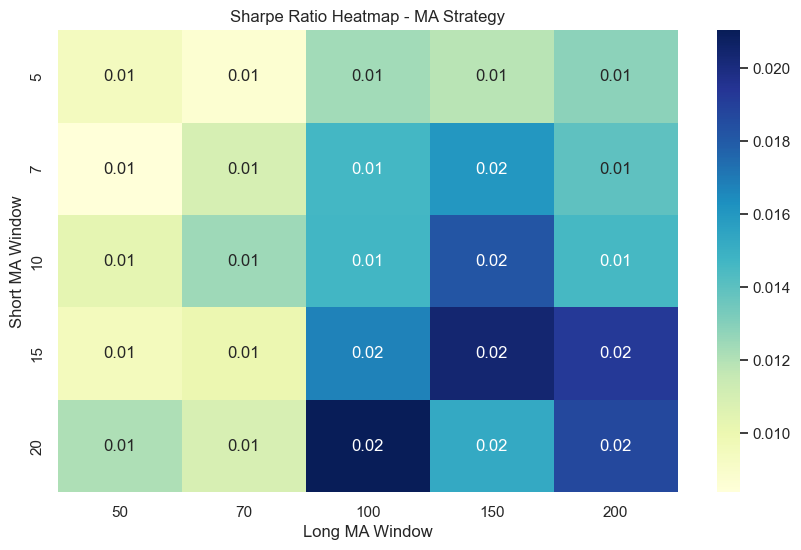

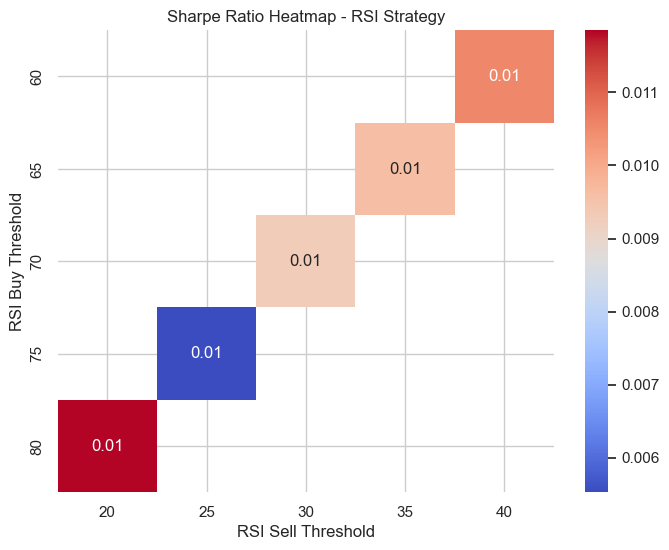

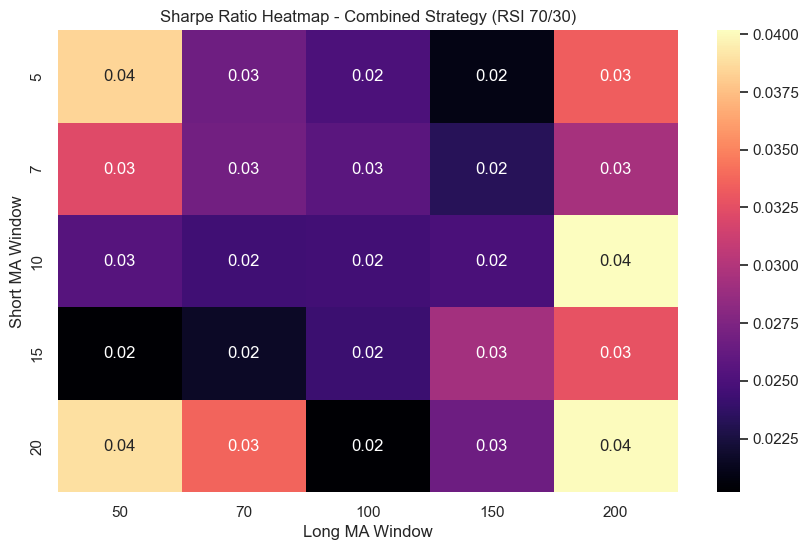

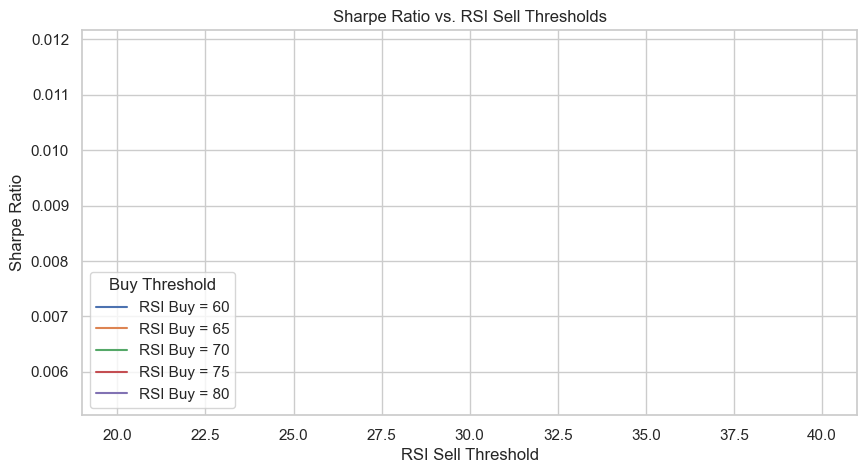

In [6]:
# ===============================
# 📊 Strategy Performance Visualizations
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

# Set theme
sns.set(style="whitegrid")

# --- 1. Heatmap for MA Strategy ---
ma_pivot = ma_results_df.pivot(index="Short_MA", columns="Long_MA", values="Sharpe")
plt.figure(figsize=(10, 6))
sns.heatmap(ma_pivot, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Sharpe Ratio Heatmap - MA Strategy")
plt.xlabel("Long MA Window")
plt.ylabel("Short MA Window")
plt.show()

# --- 2. Heatmap for RSI Strategy ---
rsi_pivot = rsi_results_df.pivot(index="RSI_Buy", columns="RSI_Sell", values="Sharpe")
plt.figure(figsize=(8, 6))
sns.heatmap(rsi_pivot, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Sharpe Ratio Heatmap - RSI Strategy")
plt.xlabel("RSI Sell Threshold")
plt.ylabel("RSI Buy Threshold")
plt.show()

# --- 3. Heatmap for Combined Strategy (Fixed RSI Buy/Sell = 70/30) ---
filtered_combined = combined_results_df[
    (combined_results_df['RSI_Buy'] == 70) & (combined_results_df['RSI_Sell'] == 30)
]
combined_pivot = filtered_combined.pivot(index="Short_MA", columns="Long_MA", values="Sharpe")
plt.figure(figsize=(10, 6))
sns.heatmap(combined_pivot, annot=True, cmap="magma", fmt=".2f")
plt.title("Sharpe Ratio Heatmap - Combined Strategy (RSI 70/30)")
plt.xlabel("Long MA Window")
plt.ylabel("Short MA Window")
plt.show()

# --- 4. Line Plot: Sharpe Across RSI Thresholds ---
plt.figure(figsize=(10, 5))
for buy, group in rsi_results_df.groupby('RSI_Buy'):
    plt.plot(group['RSI_Sell'], group['Sharpe'], label=f'RSI Buy = {buy}')
plt.title("Sharpe Ratio vs. RSI Sell Thresholds")
plt.xlabel("RSI Sell Threshold")
plt.ylabel("Sharpe Ratio")
plt.legend(title="Buy Threshold")
plt.grid(True)
plt.show()


Rules based Momentum startegy

Understand the concept of momentum
    ▪ Relative Strength Index (RSI)
    ▪ Write code to calculate these

Tasks:
    1. Implement a strategy that buys assets when momentum indicators signal strength (e.g., RSI > 70) and sells when they signal weakness (e.g., RSI < 30).
    2. Combine momentum signals with moving averages to enhance the strategy.
    3. Test the algorithm on a broad range of stocks (at least 100) from the S&P index
    4. You should report average P&L and variance of P&L for each combination of moving average periods
    5. Once again try five best combinations of RSI you can find both alone and combined with moving averages

ML based Moving average strategy

Tasks:
    1. Build a Deep Learning model that takes in the stock prices and ML indicators and RSI indicators as features
    2. Use a 3-layer neural network (1 hidden layers) where the inputs are the indicators and the output is a buy, sell or hold signal
    3. You train it over a subset of the time series
    4. You test it on another part of the timeseries
    5. See if the changing number of layers or neurons per layer helps
    6. Test the algorithm on a broad range of stocks (at least 100) from the S&P index
    7. You should report average P&L and variance of P&L

ML based Momentum strategy

Tasks:
    1. Implement a strategy that buys assets when momentum indicators signal strength (e.g., RSI > 70) and sells when they signal weakness (e.g., RSI < 30).
    2. Combine momentum signals with moving averages to enhance the strategy.
    3. Once again try five best combinations of RSI you can find both alone and combined with moving averages
    4. Use a machine learning algorithm with price, and various MA values and RSI as features to see if you can predict buy and sell

Strategy 2: Value-Based Strategies

Objectives:
• Understand fundamental metrics such as P/E ratios, book value
• Backtest value-based strategies using historical data.
• Evaluate the performance of the strategies.

Tasks:
    1. Buy stocks with low P/E ratio compared to historical average
    2. The Price-to-Book ratio compares a company's market value to its book value (the net asset value on the balance sheet). A low P/B ratio may indicate that the stock is undervalued relative to its assets.
    3. Use a machine learning algorithm with price, P/E and PtB values as features to see if you can predict buy and sell

Sharpe Ratio: 4.0
Max Drawdown: -69.0 %
Total Return: 9.919243927977172e+42 %


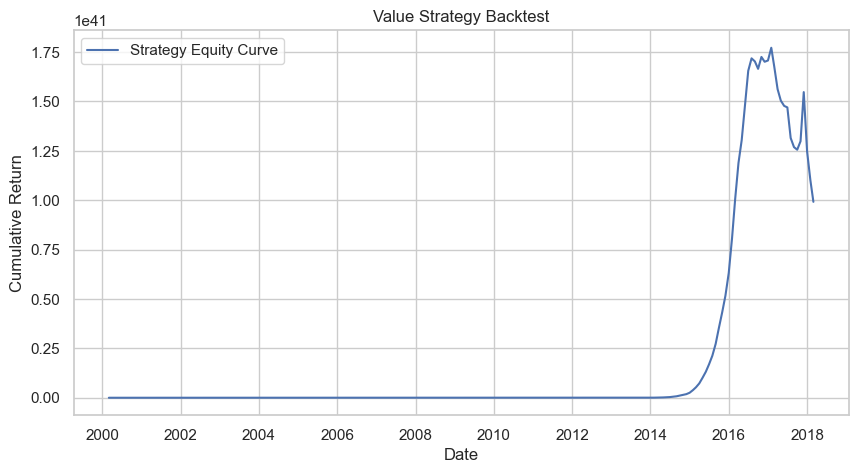

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Load data
df = pd.read_csv('cleaned_stock_pe_pb_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Stock', 'Date'])

# Calculate rolling averages for PE and PB
df['PE_avg'] = df.groupby('Stock')['PE'].transform(lambda x: x.rolling(window=252, min_periods=60).mean())
df['PB_avg'] = df.groupby('Stock')['PB'].transform(lambda x: x.rolling(window=252, min_periods=60).mean())

# Generate buy signals when PE and PB are below historical averages
df['Buy_Signal'] = (df['PE'] < df['PE_avg']) & (df['PB'] < df['PB_avg'])

# Monthly rebalancing: pick stocks to buy on the first trading day of each month
monthly_signals = df[df['Buy_Signal']].copy()
monthly_signals['Month'] = monthly_signals['Date'].dt.to_period('M')

# Pick first signal in each month per stock
buy_dates = monthly_signals.groupby(['Month', 'Stock'])['Date'].min().reset_index()
portfolio = df.merge(buy_dates, on=['Date', 'Stock'], how='inner')

# Simulate returns: holding for 21 trading days (approx. 1 month)
portfolio['Future_Price'] = portfolio.groupby('Stock')['Close'].shift(-21)
portfolio['Return'] = (portfolio['Future_Price'] - portfolio['Close']) / portfolio['Close']

# Drop NaNs and calculate average monthly return
portfolio = portfolio.dropna(subset=['Return'])
monthly_returns = portfolio.copy()
monthly_returns['Month'] = monthly_returns['Date'].dt.to_period('M')
monthly_returns = monthly_returns.groupby('Month')['Return'].mean()

# Calculate performance metrics
cumulative_returns = (1 + monthly_returns).cumprod()
cumulative_returns.index = cumulative_returns.index.to_timestamp()
sharpe_ratio = monthly_returns.mean() / monthly_returns.std() * np.sqrt(12)
max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()

# Print metrics
print("Sharpe Ratio:", round(sharpe_ratio, 2))
print("Max Drawdown:", round(max_drawdown * 100, 2), "%")
print("Total Return:", round(cumulative_returns.iloc[-1] * 100, 2), "%")

# Plot equity curve
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns.index, cumulative_returns.values, label='Strategy Equity Curve')
plt.title('Value Strategy Backtest')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


Strategy 3: Sentiment-Based Strategies.

▪ Understand and implement sentiment-based trading strategies.
▪ Analyze sentiment data from news articles, social media, and other sources.
▪ Backtest sentiment-based strategies using historical sentiment data.
▪ Evaluate the performance of sentiment-based strategies.

Implement a Sentiment-Based Trading Strategy:
    ▪ Develop a strategy that buys stocks with positive sentiment and sells stocks with negative sentiment.
    ▪ Experiment with different thresholds for sentiment scores to refine the strategy.
    ▪ Combine sentiment analysis with the moving average and value-based strategies from previous sections.
    ▪ Explore how sentiment signals can enhance or detract from other strategies.
    ▪ Use historical sentiment data alongside market data to backtest the sentiment-based strategy.

In [ ]:
import pandas as pd

# Load the data
price_df = pd.read_csv("DF_fully_cleaned_stock_data.csv")
pe_df = pd.read_csv("PE RATIO.csv")
ptb_df = pd.read_csv("price_to_book_ratio.csv")

# Parse date columns
price_df['Date'] = pd.to_datetime(price_df['Date'])
pe_df['Dates'] = pd.to_datetime(pe_df['Dates'], format='%d-%m-%Y')
ptb_df['Date'] = pd.to_datetime(ptb_df['Date'], format='%d-%m-%Y')

# Melt the data to long format
price_melted = price_df.melt(id_vars='Date', var_name='Stock', value_name='Close')
pe_melted = pe_df.melt(id_vars='Dates', var_name='Stock', value_name='PE').rename(columns={'Dates': 'Date'})
ptb_melted = ptb_df.melt(id_vars='Date', var_name='Stock', value_name='PB')

# Clean ticker names
clean = lambda x: x.replace('_adjclose', '').replace(' UW Equity', '').replace(' UN Equity', '').strip()
price_melted['Stock'] = price_melted['Stock'].apply(clean)
pe_melted['Stock'] = pe_melted['Stock'].apply(clean)
ptb_melted['Stock'] = ptb_melted['Stock'].apply(clean)

# Merge datasets
merged_df = price_melted.merge(pe_melted, on=['Date', 'Stock'], how='inner')
merged_df = merged_df.merge(ptb_melted, on=['Date', 'Stock'], how='inner')
merged_df = merged_df.dropna()

# Export
merged_df.to_csv("cleaned_stock_pe_pb_data.csv", index=False)
